# Sparse-pole representation

## Theory

We explain how to transform expansion coefficients in IR to sparse-pole representation (SPR) [1,2].
We model the spectral function as

$$
    \rho(\omega) = \sum_{p=1}^L c_p \delta(\omega - \bar{\omega}_p),
$$

where sampling frequencies $\{\bar{\omega}_1, \cdots, \bar{\omega}_{L}\}$ are chosen to the extrema of $V'_{L-1}(\omega)$.
This choice is heuristic but allows us a numerically stable transform between $\rho_l$ and $c_p$ through the relation

$$
\rho_l = \sum_{p=1}^L \boldsymbol{V}_{lp} c_p,
$$

where the matrix $\boldsymbol{V}_{lp}~[\equiv V_l(\bar{\omega}_p)]$ is well-conditioned.
Notet that Discrete Lehmann Representation (DLR) [3] choose poles in a more systematic way.
As a result, in SPR, the Green's function is represented as

$$
G(\mathrm{i}\omega_n) = \sum_{p=1}^L \frac{c_p}{\mathrm{i}\omega_n - \bar{\omega}_p}.
$$

[1] H. Shinaoka and Y. Nagai, Phys. Rev. B 103, 045120 (2021).<br>
[2] H. Shinaoka et al., arXiv:2106.12685v2.<br>
[3] J. Kaye, K. Chen, O. Parcollet, arXiv:2107.13094v2.<br>

We consider the semi circular DOS

$$
\rho(\omega) = \sqrt{\frac{2}{\pi}} \sqrt{1-\omega^2}.
$$

The corresponding Green's function is given by

$$
G(\mathrm{i}\omega_n) = \int_{-1}^1 \mathrm{d}\omega \frac{\rho(\omega)}{\mathrm{i}\omega_n - \omega}.
$$

The Green's function is expanded in IR as

$$
G_l = - S_l \int_{-1}^1 \mathrm{d}\omega \rho(\omega) V_l(\omega).
$$

Below, we demonstrate how to transform $G_l$ to the SPR coefficients $c_p$.

In [1]:
using SparseIR
using Plots
gr() # USE GR backend
#using OMEinsum
using LaTeXStrings

## Implementation

### Create basis object

In [2]:
wmax = 1.0
lambda_ = 1e+4
beta = lambda_/wmax

basis = FiniteTempBasis(fermion, beta, wmax, 1e-15)
print(length(basis))

104

### Setup model

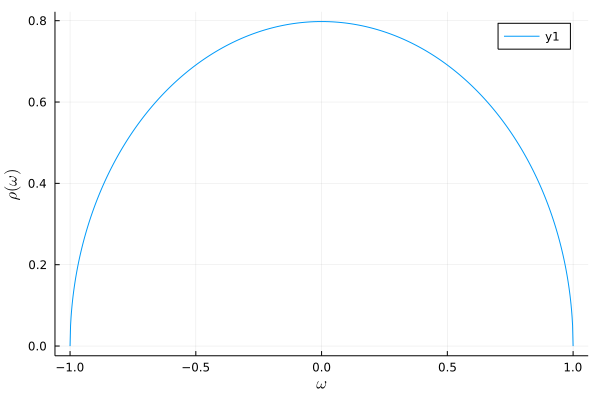

In [3]:
rho(omega) = sqrt(1-omega^2)/sqrt(0.5*π)

omega = LinRange(-wmax, wmax, 1000)
plot(omega, rho.(omega), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

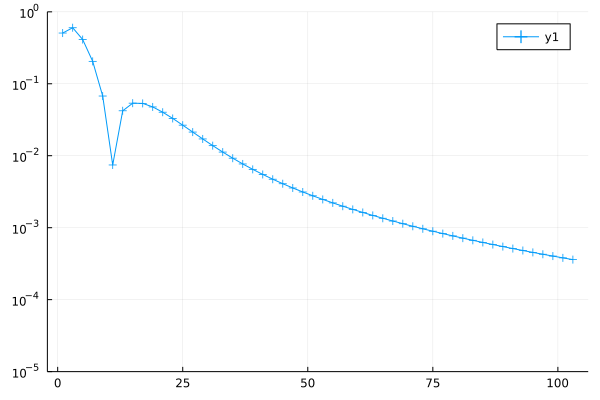

In [4]:
rhol = overlap(basis.v, rho)
ls = collect(1:length(basis))
plot(ls[1:2:end], abs.(rhol)[1:2:end], marker=:cross, yaxis=:log, ylims=(1e-5,1))

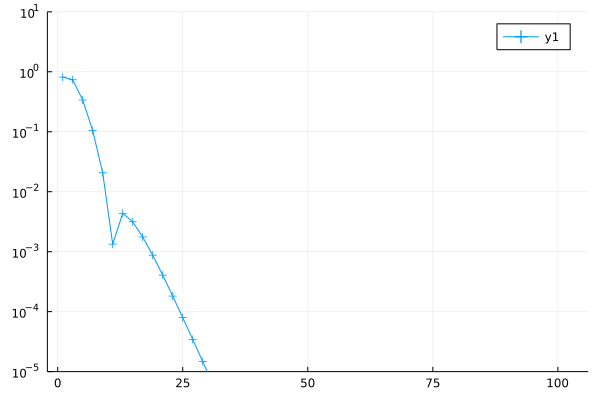

In [5]:
gl = - basis.s .* rhol
plot(ls[1:2:end], abs.(gl)[1:2:end], marker=:cross, ylims=(1e-5,10), yaxis=:log)

### Create a SPR object and perform transformation

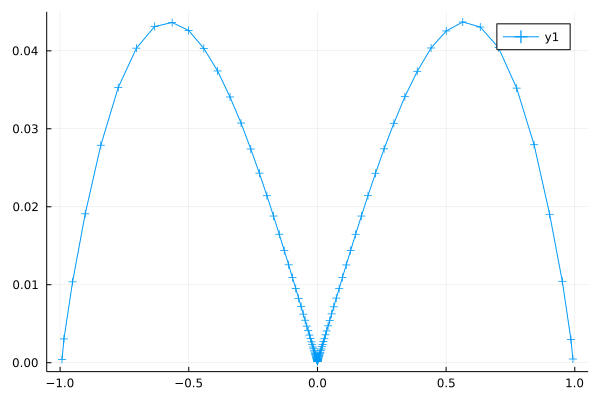

In [6]:
spr = SparsePoleRepresentation(basis)

# To SPR
g_spr = from_IR(spr, gl)

plot(spr.poles, g_spr, marker=:cross)

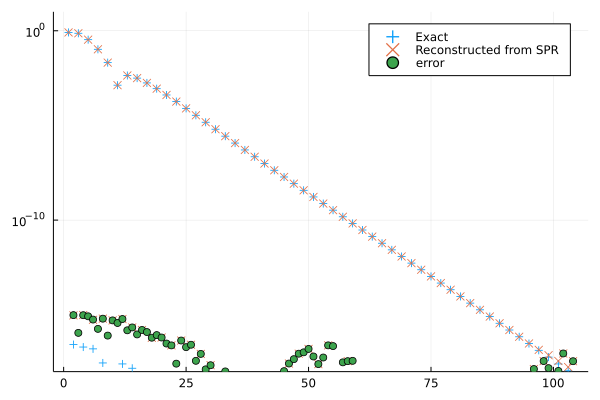

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/jovyan/.julia/packages/Plots/1KWPG/src/utils.jl:95


In [7]:
# Transform back to IR from SPR
gl_reconst = to_IR(spr, g_spr)

plot(
    [abs.(gl), abs.(gl_reconst), abs.(gl-gl_reconst)],
    label=["Exact" "Reconstructed from SPR" "error"],
    marker=[:cross :x :circle], line=(nothing,nothing,nothing), yaxis=:log,
    ylims=(1e-18,10)
)

### Evaluation on Matsubara frequencies

┌ Warning: Sampling matrix is poorly conditioned (cond = 3.981693781449279e15).
└ @ SparseIR /home/jovyan/.julia/packages/SparseIR/6HApe/src/sampling.jl:91


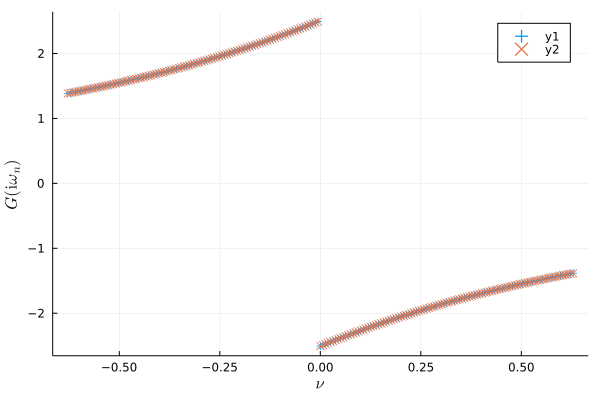

In [8]:
v = 2 .* collect(-1000:10:1000) .+ 1
iv = (im * (π/beta)) .* v

newaxis = [CartesianIndex()]
transmat = 1 ./ (iv[:,newaxis] .- spr.poles[newaxis,:])
giv = transmat * g_spr

smpl = MatsubaraSampling(basis, v)
giv_exact = evaluate(smpl, gl)

plot(
    imag.(iv), [imag.(giv_exact), imag.(giv)], marker=[:cross :x], line=(nothing,nothing),
    xlabel=latexstring("\\nu"),
    ylabel=latexstring("G(\\mathrm{i}\\omega_n)")
    )